# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

**Данное исследование разделим на несколько частей.**

***Часть 1. Подготовка данных:***
* [1. Изученеие файлов с данными, загрузка библиотек.](#info1)
* [2. Получение общей информации.](#info2)
* [3. Нахождение и ликвидация пропусков.](#preparation1)
* [4. Нахождение и ликвидация аномальных значений.](#preparation2)
* [5. Нахождение и ликвидация дубликатов.](#preparation3)

[***Часть 2.Обучение моделей:***](#models)
* [1. LinearRegression.](#linear)
* [2. DecisionTreeRegressor.](#tree)
* [3. LightGBM.](#booster)

***Часть 3. Анализ моделей:***
* [Выводы.](#conclusion)


## Подготовка данных

<a id='info1'></a>
### Загрузка библиотек

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import phik

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

RANDOM_STATE = 42

### Загрузка данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')

<a id='info2'></a>
### Обзор данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
332714,2016-03-11 15:36:20,14900,suv,2010,manual,140,qashqai,40000,12,petrol,nissan,no,2016-03-11 00:00:00,0,68782,2016-03-27 18:15:51
3499,2016-03-12 11:47:06,7299,wagon,2008,manual,105,golf,125000,6,gasoline,volkswagen,no,2016-03-12 00:00:00,0,57439,2016-03-16 12:15:52
329046,2016-03-12 22:36:59,3000,small,2009,manual,67,i_reihe,100000,5,petrol,hyundai,no,2016-03-12 00:00:00,0,1744,2016-04-04 10:17:28
284975,2016-03-17 09:51:09,9950,wagon,2012,manual,101,focus,100000,12,petrol,ford,no,2016-03-17 00:00:00,0,72070,2016-04-06 06:16:33
28197,2016-03-15 16:53:56,7400,wagon,2010,manual,120,2_reihe,80000,10,petrol,peugeot,no,2016-03-15 00:00:00,0,66802,2016-04-06 12:17:20


<a id='preparation1'></a>
### Поиск и удаление пропусков

In [6]:
data.isna().sum() 

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
bad_data = data.loc[(data['VehicleType'].isna() == True) & (data['Model'].isna() == True)]

In [8]:
bad_data.shape[0] / data.shape[0] * 100

1.9268051099277872

In [9]:
df = data.drop(bad_data.index)

Удалили неинформативные данные. Ведь не зная ни тип кузова ни модели автомобиля определить его ценность маловероятно.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347541 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        347541 non-null  object
 1   Price              347541 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   347541 non-null  int64 
 4   Gearbox            330720 non-null  object
 5   Power              347541 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          347541 non-null  int64 
 8   RegistrationMonth  347541 non-null  int64 
 9   FuelType           318960 non-null  object
 10  Brand              347541 non-null  object
 11  Repaired           280863 non-null  object
 12  DateCreated        347541 non-null  object
 13  NumberOfPictures   347541 non-null  int64 
 14  PostalCode         347541 non-null  int64 
 15  LastSeen           347541 non-null  object
dtypes: int64(7), object(

In [11]:
(df.isna().sum() / len(df)).round(4) * 100

DateCrawled           0.00
Price                 0.00
VehicleType           8.82
RegistrationYear      0.00
Gearbox               4.84
Power                 0.00
Model                 3.71
Kilometer             0.00
RegistrationMonth     0.00
FuelType              8.22
Brand                 0.00
Repaired             19.19
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

In [12]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [13]:
df['VehicleType'].fillna('other', inplace=True)

In [14]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [15]:
df['Gearbox'].fillna('other', inplace=True)

In [16]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [17]:
df['Model'].fillna('other', inplace=True)

In [18]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [19]:
df['FuelType'].fillna('other', inplace=True)

In [20]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [21]:
df['Repaired'].fillna('other', inplace=True)

In [22]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

<a id='preparation2'></a>
### Поиск и исправление аномальных значений

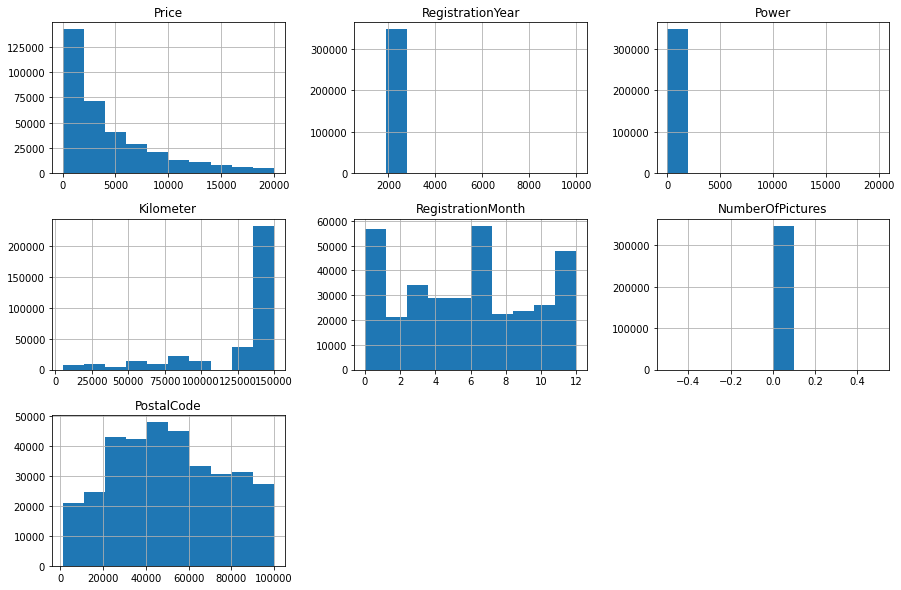

In [23]:
df.hist(figsize=(15, 10));

In [24]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,347541.000000,347541.000000,347541.000000,347541.000000,347541.000000,347541.0,347541.000000
mean,4463.647975,2003.714273,111.155518,128449.636158,5.770519,0.0,50574.194872
std,4524.298684,68.114605,190.550535,37472.466565,3.702707,0.0,25777.321752
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30171.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49477.000000
75%,6499.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71126.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


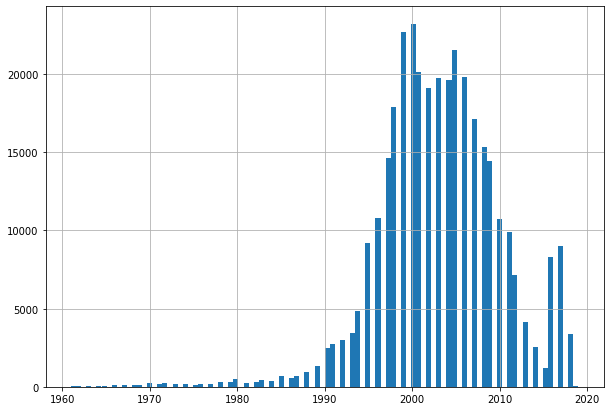

In [25]:
df.loc[(df['RegistrationYear'] > 1960) & (df['RegistrationYear'] < 2020), 'RegistrationYear'].hist(figsize=(10, 7), bins=100);

In [26]:
bad_year = df.loc[(df['RegistrationYear'] < 1990) & (df['RegistrationYear'] > 2016)]

In [27]:
df = df.drop(bad_year.index)

In [28]:
df['RegistrationYear'].describe()

count    347541.000000
mean       2003.714273
std          68.114605
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [29]:
bad_power = df.loc[(df['Power'] < 50) & (df['Power'] > 500)]

In [30]:
df = df.drop(bad_power.index)

In [31]:
df['Power'].describe()

count    347541.000000
mean        111.155518
std         190.550535
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [32]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,347541.000000,347541.000000,347541.000000,347541.000000,347541.000000,347541.0,347541.000000
mean,4463.647975,2003.714273,111.155518,128449.636158,5.770519,0.0,50574.194872
std,4524.298684,68.114605,190.550535,37472.466565,3.702707,0.0,25777.321752
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30171.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49477.000000
75%,6499.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71126.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347541 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        347541 non-null  object
 1   Price              347541 non-null  int64 
 2   VehicleType        347541 non-null  object
 3   RegistrationYear   347541 non-null  int64 
 4   Gearbox            347541 non-null  object
 5   Power              347541 non-null  int64 
 6   Model              347541 non-null  object
 7   Kilometer          347541 non-null  int64 
 8   RegistrationMonth  347541 non-null  int64 
 9   FuelType           347541 non-null  object
 10  Brand              347541 non-null  object
 11  Repaired           347541 non-null  object
 12  DateCreated        347541 non-null  object
 13  NumberOfPictures   347541 non-null  int64 
 14  PostalCode         347541 non-null  int64 
 15  LastSeen           347541 non-null  object
dtypes: int64(7), object(

In [34]:
new_df = df.drop(['RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen', 'DateCrawled'], axis=1)

<a id='preparation3'></a>
### Поиск и удаление дубликатов

In [35]:
new_df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,other
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354364,0,other,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [36]:
new_df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'land_rover', 'trabant', 'lada'], dtype=object)

In [37]:
new_df['FuelType'].unique()

array(['petrol', 'gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [38]:
new_df['FuelType'] = new_df['FuelType'].replace('gasoline', 'petrol', regex=True)

In [39]:
new_df['FuelType'] = new_df['FuelType'].replace(['lpg', 'cng'], 'gas', regex=True)

In [40]:
new_df.duplicated().sum()

45191

In [41]:
new_df = new_df.drop_duplicates()

In [42]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302350 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             302350 non-null  int64 
 1   VehicleType       302350 non-null  object
 2   RegistrationYear  302350 non-null  int64 
 3   Gearbox           302350 non-null  object
 4   Power             302350 non-null  int64 
 5   Model             302350 non-null  object
 6   Kilometer         302350 non-null  int64 
 7   FuelType          302350 non-null  object
 8   Brand             302350 non-null  object
 9   Repaired          302350 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.4+ MB


**Вывод:**  Изучили данные. Заполнили пропущенные значения и обработали аномалии в столбцах. Неинформативные данные удалили.

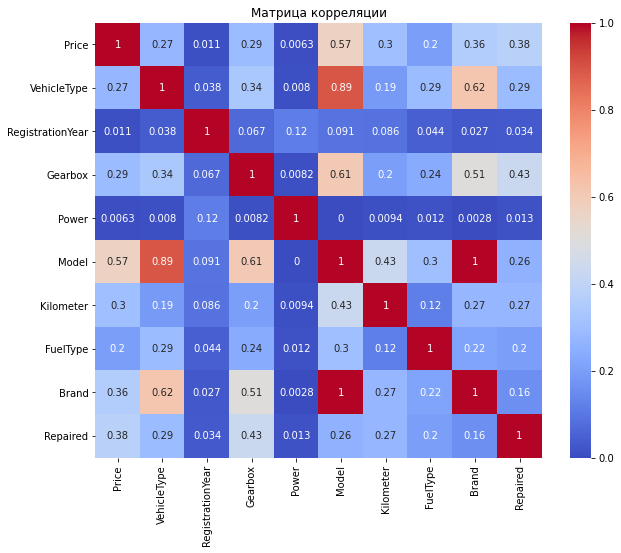

In [43]:
list_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
corr_matrix = new_df.phik_matrix(interval_cols = list_columns)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

<a id='models'></a>
## Обучение моделей

In [44]:
df_sample = new_df.drop('Brand', axis=1).sample(frac=0.1, random_state=RANDOM_STATE)

In [45]:
X = df_sample.drop('Price', axis=1)
y = df_sample['Price']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [47]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
ord_columns = ['Model']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns), # handle_unknown='error'
    ('ord', OrdinalEncoder(), ord_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

In [48]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

result = pd.DataFrame(randomized_search.cv_results_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    


## Анализ моделей

In [57]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.116722,0.007668,0.011608,0.001518,StandardScaler(),DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-2759.528239,NaN,NaN,-2847.882331,-2749.707803,NaN,NaN,1
1,0.113535,0.005855,0.011181,0.001566,MinMaxScaler(),DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models'...",-2764.509243,NaN,NaN,-2845.304750,-2751.006201,NaN,NaN,2
2,0.109535,0.003047,0.011034,0.002131,passthrough,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models':...",-2760.626178,NaN,NaN,-2845.564431,-2748.713379,NaN,NaN,3
3,0.161709,0.064684,0.071963,0.034035,StandardScaler(),LinearRegression(),"{'preprocessor__num': StandardScaler(), 'model...",-3737.801448,NaN,NaN,-3682.619360,-6707.317045,NaN,NaN,4
4,0.175108,0.041502,0.070523,0.059945,MinMaxScaler(),LinearRegression(),"{'preprocessor__num': MinMaxScaler(), 'models'...",-3737.801448,NaN,NaN,-3682.619360,-6707.317045,NaN,NaN,5
5,0.162898,0.043299,0.083346,0.050279,passthrough,LinearRegression(),"{'preprocessor__num': 'passthrough', 'models':...",-3737.801448,NaN,NaN,-3682.619360,-6707.317045,NaN,NaN,6
6,78.172006,153.461284,0.068388,0.047545,StandardScaler(),LGBMRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-1950.194432,NaN,NaN,-2065.395389,-1910.275957,NaN,NaN,7
7,1.629116,0.241933,0.069305,0.047857,MinMaxScaler(),LGBMRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models'...",-1956.042704,NaN,NaN,-2064.865437,-1901.465722,NaN,NaN,8
8,1.392194,0.064258,0.123853,0.039100,passthrough,LGBMRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models':...",-1956.042704,NaN,NaN,-2064.865437,-1901.465722,NaN,NaN,9


In [58]:
X = new_df.drop(['Price', 'Brand'], axis=1)
y = new_df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [59]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_col_names = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
num_col_names = ['RegistrationYear', 'Power', 'Kilometer']

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])


encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred) 
print("Качество предсказания - RMSE: {}".format(np.sqrt(mse)))

Качество предсказания - RMSE: 1910.8369892403107


<a id='conclusion'></a>
### Вывод

Проанализировав 3 модели: линейная, дерево и бустер. Лучшей по качеству оказалось LGBMRegressor, но время на обучения ушло гораздо больше в сравнении с DecisionTreeRegressor(). Возможно настроив гиперпараметры лучше, может измениться.